In [1]:
#1. How to process csv files or custom datasets(not keras dataset)
#2. How to use transfer learning
#3. Build an LSTM model
#4. Stacked LSTM
#5. Predictions (i/p: sentence  o/p: most suitable class)

In [74]:
import os, sys, email,re
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set_style('whitegrid')

# NLP
from nltk.tokenize.regexp import RegexpTokenizer
#from subprocess import check_output

#from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
#from sklearn.cluster import KMeans
#from sklearn.decomposition import PCA
#from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
#from sklearn.decomposition import LatentDirichletAllocation

import gensim
from gensim import corpora
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string
from nltk.stem.porter import PorterStemmer
from nltk import pos_tag, word_tokenize

## Step 1: Load dataset

In [75]:
# from sklearn.utils import shuffle

# emails_df = pd.read_csv('./emails.csv', nrows=20000)
df = pd.read_csv('./emaildataset.csv')
# df.sample(frac=1)
# df.sample(n=len(df), random_state=42)
# df.reindex(np.random.permutation(df.index))

print(df.shape)
df.head()

(9860, 7)


,From,To,Subject,Body,Class,TransactionID,Payment Date
0,Yasmin@BNYMellon.com,Shai@CitiBankHingKong.com,Send collateral details for loan no. 855774,We are happy to let you know that transaction ...,BankComplete,855774,2019-11-24
1,Mike@HSBC.com,Isabella@CitiBankSingapore.com,Payment Status for 524486,"Due to lack of funds, cheque no. 9766871231991...",BankFailed,524486,2020-03-28
2,Phillip@DEUTSCHEBANK.com,AjayNager@CitiBankNewYork.com,Acknowledgement of loan request no. 874719,Please be assured that we have received your r...,BankRequest,874719,2018-12-24
3,Archie@HDFC.com,Neha@CitiBankPune.com,Payment Status for 533328,We regret the delay in completing transaction ...,BankProgress,533328,2019-12-06
4,David@JPMorgan.com,Sumit@CitiBankNewYork.com,Current Update on Account No. 184124,"Hi, We have successfully processed and complet...",BankComplete,184124,2019-09-14


In [76]:
df.Class.unique()

array(['BankComplete', 'BankFailed', 'BankRequest', 'BankProgress', nan,
       'ClientProgress', 'ClientComplete', 'ClientStatus', 'ClientFailed'],
      dtype=object)

In [78]:
import spacy

In [80]:
import en_core_web_sm
nlp = en_core_web_sm.load()

In [84]:
lemma = spacy.load('en')

In [93]:
def clean(text):
#     stop = set(stopwords.words('english'))
#     stop.update(("to","cc","subject","http","from", "gbp", "usd", "eur", "cad", "sent","thanks", "acc", "id", "account", "regards", "hi", "hello", "thank you"))
#     operators = set(('and', 'or', 'not'))
#     stop = set(stop) - operators
    stop = set(("cc","http", "subject", "gbp", "usd", "eur", "cad", "inr", "sent","thanks", "acc", "id", "regards", "hi", "hello", "thank you"))
    exclude = set(string.punctuation) 

#     lemma = WordNetLemmatizer()
#     porter= PorterStemmer()
    
    text=text.rstrip()
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    # IS AMOUNT EXTRACTION  NEEDED?
    #amount = "".join([i for i in text.lower().split() if i.isdigit()])
    
    stop_free = " ".join([i for i in text.lower().split() if((i not in stop) and (not i.isdigit()))])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    doc = lemma(punc_free)
#     normalized = " ".join(lemma(word) for token in punc_free.split())
    normalized = " ".join(token.lemma_ for token in doc)
#     stem = " ".join(porter.stem(token) for token in normalized.split())
    
#     return normalized, amount
    return normalized

In [94]:
print(clean("payment has been freezed"))

payment have be freeze


In [95]:
for i in range(df.shape[0]):
    # merge subject and body strings
    df['Text_Data'] = str(df['Subject'] + " " + df['Body'])

In [96]:
print(type(df.values[i][7]))

<class 'str'>


In [97]:
df.head()

,From,To,Subject,Body,Class,TransactionID,Payment Date,Text_Data
0,Yasmin@BNYMellon.com,Shai@CitiBankHingKong.com,Send collateral details for loan no. 855774,We are happy to let you know that transaction ...,BankComplete,855774,2019-11-24,0 Send collateral details for loan no. 8...
1,Mike@HSBC.com,Isabella@CitiBankSingapore.com,Payment Status for 524486,"Due to lack of funds, cheque no. 9766871231991...",BankFailed,524486,2020-03-28,0 Send collateral details for loan no. 8...
2,Phillip@DEUTSCHEBANK.com,AjayNager@CitiBankNewYork.com,Acknowledgement of loan request no. 874719,Please be assured that we have received your r...,BankRequest,874719,2018-12-24,0 Send collateral details for loan no. 8...
3,Archie@HDFC.com,Neha@CitiBankPune.com,Payment Status for 533328,We regret the delay in completing transaction ...,BankProgress,533328,2019-12-06,0 Send collateral details for loan no. 8...
4,David@JPMorgan.com,Sumit@CitiBankNewYork.com,Current Update on Account No. 184124,"Hi, We have successfully processed and complet...",BankComplete,184124,2019-09-14,0 Send collateral details for loan no. 8...
...,...,...,...,...,...,...,...,...
95,Jason@JPMorgan.com,Shai@CitiBankLondon.com,Current Update on Account No. 212176,"Due to lack of funds, cheque no. 6232212988467...",BankFailed,212176,2019-04-03,0 Send collateral details for loan no. 8...
96,Bella@HSBC.com,Neha@CitiBankLondon.com,Request has been received for Transaction-ID: ...,We are pleased to know that you have chosen us...,BankRequest,218984,2019-06-09,0 Send collateral details for loan no. 8...
97,Phillip@HSBC.com,Patrick@CitiBankHingKong.com,Transaction 997587 failedPayment Failed for 99...,Regret to inform that transaction EUR 777129 c...,BankFailed,997587,2018-12-21,0 Send collateral details for loan no. 8...
98,Yasmin@HSBC.com,liFang@CitiBankSingapore.com,Urgent : Account details required for 148132,We regret the delay in completing transaction ...,BankProgress,148132,2019-05-24,0 Send collateral details for loan no. 8...


In [98]:
# sub_df["content"]=sub_df["content"].map(clean)
text_clean=[]

# for text in df['Text_Data']:
#     text_clean.append(clean(text))
#     text_clean.append(clean(text).split())
#     amount = clean(text)[1]
# 
for i in range(df.shape[0]):
    text_clean.append(clean(df.loc[i]['Text_Data']))

# amount
text_clean[0]
# print(type(df.values[i][7]))

'send collateral detail for loan no -PRON- payment status for due to lack of fund acknowledgement of loan request no ple payment status for -PRON- regret the delay current update on account no -PRON- ha loan payment be complete for no as sta transaction be in progress for why be m transaction be in progress for why be m information regard collateral detail for l transaction be in progress for thank yo length dtype object'

In [99]:
df['Text_Data'] = text_clean

In [104]:
df.Text_Data.unique()

array(['send collateral detail for loan no -PRON- payment status for due to lack of fund acknowledgement of loan request no ple payment status for -PRON- regret the delay current update on account no -PRON- ha loan payment be complete for no as sta transaction be in progress for why be m transaction be in progress for why be m information regard collateral detail for l transaction be in progress for thank yo length dtype object'],
      dtype=object)

In [100]:
df.head()

,From,To,Subject,Body,Class,TransactionID,Payment Date,Text_Data
0,Yasmin@BNYMellon.com,Shai@CitiBankHingKong.com,Send collateral details for loan no. 855774,We are happy to let you know that transaction ...,BankComplete,855774,2019-11-24,send collateral detail for loan no -PRON- paym...
1,Mike@HSBC.com,Isabella@CitiBankSingapore.com,Payment Status for 524486,"Due to lack of funds, cheque no. 9766871231991...",BankFailed,524486,2020-03-28,send collateral detail for loan no -PRON- paym...
2,Phillip@DEUTSCHEBANK.com,AjayNager@CitiBankNewYork.com,Acknowledgement of loan request no. 874719,Please be assured that we have received your r...,BankRequest,874719,2018-12-24,send collateral detail for loan no -PRON- paym...
3,Archie@HDFC.com,Neha@CitiBankPune.com,Payment Status for 533328,We regret the delay in completing transaction ...,BankProgress,533328,2019-12-06,send collateral detail for loan no -PRON- paym...
4,David@JPMorgan.com,Sumit@CitiBankNewYork.com,Current Update on Account No. 184124,"Hi, We have successfully processed and complet...",BankComplete,184124,2019-09-14,send collateral detail for loan no -PRON- paym...


In [101]:
df['Text_Data'][1005]

'send collateral detail for loan no -PRON- payment status for due to lack of fund acknowledgement of loan request no ple payment status for -PRON- regret the delay current update on account no -PRON- ha loan payment be complete for no as sta transaction be in progress for why be m transaction be in progress for why be m information regard collateral detail for l transaction be in progress for thank yo length dtype object'

In [103]:
df['Subject'][1005] + " " + df['Body'][1005]

'Request has been received for Transaction-ID: 679295 Please find the details of your account 679295 attached'

## Step 2: Split into train/test 

In [40]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2)

In [41]:
train.shape

(6560, 8)

In [44]:
z1 = train.values
z2 = test.values

# Create Training and Testing Set
X_train = z1[:, 7]
Y_train = z1[:, 6]

X_test = z2[:, 7]
Y_test = z2[:, 6]

# X_test.shape
Y_test.shape

(1640,)

In [45]:
train.Class.unique()

array(['BankProgress', 'BankFailed', 'ClientComplete', 'BankRequest',
       'BankComplete', 'ClientStatus', 'ClientProgress', 'ClientFailed'],
      dtype=object)

In [46]:
# import preprocessing from sklearn
from sklearn.preprocessing import OneHotEncoder 

In [48]:
# creating instance of one-hot-encoder
enc = OneHotEncoder(handle_unknown='ignore')

Y_train = Y_train.reshape(-1, 1)
Y_train = enc.fit_transform(Y_train)
# enc2 = OneHotEncoder()
# enc_train = pd.DataFrame(enc.fit_transform(train[['Class']]).toarray())

# merge with main df on key values
# train = train.join(enc_train)
# train.head()

In [49]:
enc2 = OneHotEncoder(handle_unknown='ignore')
Y_test = Y_test.reshape(-1, 1)
Y_test = enc2.fit_transform(Y_test)

In [50]:
Y_test.shape

(1640, 8)

## Step 3: Loading word2vec

In [51]:
#convert sentences to embeddings and classes to one-hot vectors

In [52]:
embeddings = {}
with open('../data_science/Machine-learning-master/17. Word2Vec/glove.6B.50d.txt',encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coeffs = np.asarray(values[1:],dtype='float32')
        
#         print(word)
#         print(coeffs)
        embeddings[word] = coeffs
    f.close()
print(len(embeddings))

400000


In [53]:
Y_train[5]

<1x8 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>

## Step 4 - Converting sentences to vectors (creating the o/p of embedding layer)

In [54]:
def getOutputEmbeddings(X):
    
    #50 batch size (no. of e.g.)
    embedding_matrix_output = np.zeros((X.shape[0],40,50))
    
    for ix in range(X.shape[0]):
        X[ix] = X[ix].split()
        for jx in range(len(X[ix])):
            embedding_matrix_output[ix][jx] = embeddings[X[ix][jx].lower()]
            
    return embedding_matrix_output

In [55]:
XT = X_train
Xt = X_test

print(XT[0])
print(XT.shape)

print(Xt[0])
print(Xt.shape)

provide detail regarding transaction hey got query regarding detail please find attached detail thank
(6560,)
payment transaction failed reason needed failure payment due error side team amount cancelled please assured reach next week
(1640,)


In [56]:
embed_matrix_train = getOutputEmbeddings(XT)
print(embed_matrix_train.shape)

(6560, 50, 50)


In [57]:
# from keras.utils import to_categorical

# YT = to_categorical(df['Class'], num_classes=8)
# Yt = to_categorical(df2['Class'], num_classes=8)

# print(YT.shape)
# print(Yt.shape)

In [58]:
embed_matrix_test = getOutputEmbeddings(Xt)
print(embed_matrix_test.shape)

(1640, 50, 50)


## Step 5: Define RNN/LSTM model 

In [59]:
from keras.layers import *
from keras.models import Sequential

In [84]:
model = Sequential()
model.add(LSTM(64,input_shape=(50,50),return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(64,input_shape=(50,50), return_sequences=False))
model.add(Dropout(0.4))
model.add(Dense(8))
model.add(Activation('softmax'))
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc']) # try optimizer='rmsprop'
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 50, 64)            29440     
_________________________________________________________________
dropout_5 (Dropout)          (None, 50, 64)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 520       
_________________________________________________________________
activation_3 (Activation)    (None, 8)                 0         
Total params: 62,984
Trainable params: 62,984
Non-trainable params: 0
__________________________________________________

In [85]:
# TRAIN MODEL

In [86]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint


#our model starts to overfit after a certain point. We can save the model upto the point where we get max valdn acc
#done using callback
checkpt = ModelCheckpoint("best_model.h5", monitor='val_loss', verbose=True, save_best_only=True)
earlystop = EarlyStopping(monitor='val_acc', patience=10)


hist = model.fit(embed_matrix_train,Y_train,batch_size=32,epochs=40,shuffle=True,validation_split=0.2, callbacks=[checkpt, earlystop])
# consider params --> model.fit(X_train,YT,validation_split=0.2,epochs=10,batch_size=128)

Train on 5248 samples, validate on 1312 samples
Epoch 1/40
5248/5248 [==============================] - 14s 3ms/step - loss: 1.3112 - acc: 0.4644 - val_loss: 0.7099 - val_acc: 0.6761

Epoch 00001: val_loss improved from inf to 0.70992, saving model to best_model.h5
Epoch 2/40
5248/5248 [==============================] - 14s 3ms/step - loss: 0.4916 - acc: 0.7782 - val_loss: 0.2802 - val_acc: 0.8895

Epoch 00002: val_loss improved from 0.70992 to 0.28020, saving model to best_model.h5
Epoch 3/40
5248/5248 [==============================] - 10s 2ms/step - loss: 0.1690 - acc: 0.9548 - val_loss: 0.0258 - val_acc: 1.0000

Epoch 00003: val_loss improved from 0.28020 to 0.02584, saving model to best_model.h5
Epoch 4/40
5248/5248 [==============================] - 10s 2ms/step - loss: 0.0281 - acc: 0.9989 - val_loss: 0.0064 - val_acc: 1.0000

Epoch 00004: val_loss improved from 0.02584 to 0.00636, saving model to best_model.h5
Epoch 5/40
5248/5248 [==============================] - 10s 2ms/step

In [87]:
pred = model.predict_classes(embed_matrix_test)

print(pred[1])

4


In [88]:
model.evaluate(embed_matrix_test,Y_test)

1640/1640 [==============================] - 1s 558us/step


[0.0010763240830473056, 1.0]

## Visualise our results

In [65]:
import matplotlib.pyplot as plt

In [66]:
h = hist.history

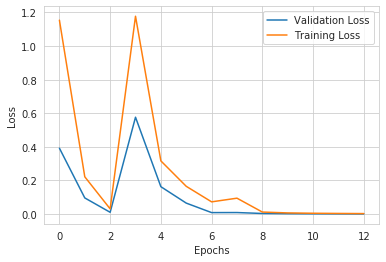

In [67]:
plt.plot(h['val_loss'],label="Validation Loss")
plt.plot(h['loss'],label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

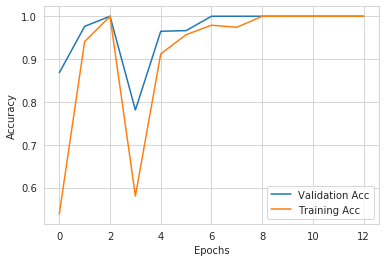

In [68]:
plt.plot(h['val_acc'],label="Validation Acc")
plt.plot(h['acc'],label="Training Acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## Testing with random strings

In [78]:
with open("model.json", "w") as file:
    file.write(model.to_json())
model.save_weights("model.h5")

In [80]:
from keras.models import model_from_json

with open("model.json", "r") as file:
    model=model_from_json(file.read())
model.load_weights("model.h5")

In [81]:
test_str="hello, is my payment done yet?"
X = pd.Series(test_str)
print(type(X))

<class 'pandas.core.series.Series'>


In [82]:
def getOutputEmbeddings(X):  
    X = X.split()
    embedding_matrix_output = np.zeros((1,10,50))
    for jx in range(len(X)):
        embedding_matrix_output[0][jx] = embeddings[X[jx].lower()]
            
    return embedding_matrix_output

In [83]:
emb_X = getOutputEmbeddings(test_str)

p = model.predict_classes(emb_X)

TypeError: 'module' object is not subscriptable

In [ ]:
p[0]

## Cells that may be useful

In [ ]:
combined = list(zip(data, labels))
random.shuffle(combined)

data[:], labels[:] = zip(*combined)

In [ ]:
hist = model_new.fit(X_train, Y_train,
                    shuffle = True,
                    batch_size=16,
                    epochs=5, #most wts have already been trained so dont need large no of epochs
                    validation_split=0.20)